In [1]:
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set the path to your dataset
home_path = './'
data_dir = os.path.join(home_path, 'emotion detection/')

# Define transformations for training and validation sets
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),        # Resize images
    transforms.RandomHorizontalFlip(),   # Randomly flip images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random brightness/contrast changes
    transforms.RandomAffine(degrees=0, shear=0.2),  # Shear transformation
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),        # Resize images
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split the dataset into training and validation sets
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = len(full_dataset) - train_size  # 30% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms to the validation dataset
val_dataset.dataset.transform = val_transforms

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

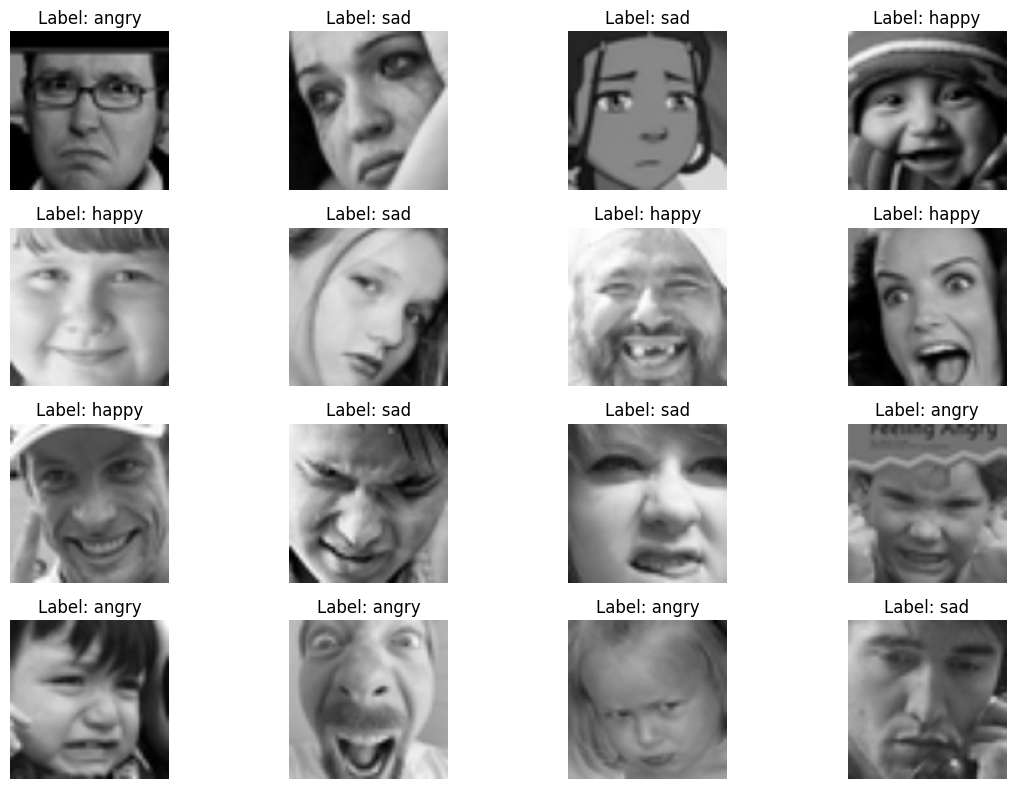

In [17]:
# Define your class mapping as a dictionary
class_mapping = {
    0: 'angry',
    1: 'happy',
    2: 'sad'
}


import matplotlib.pyplot as plt
import numpy as np

# Function to display images with their corresponding labels
def imshow(images, labels):
    
    # Convert tensor images to numpy arrays for display
    images = images.numpy().transpose((0, 2, 3, 1))  # Rearrange dimensions from (N, C, H, W) to (N, H, W, C)
    images = (images * 0.5) + 0.5  # Denormalize images to [0, 1]

    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        ax = plt.subplot(4, 4, i + 1)  # Create a 4x4 grid
        plt.imshow(images[i])
        plt.title(f'Label: {class_mapping[labels[i]]}')
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels from the training loader
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Get the next batch

# Convert labels to class indices
labels = labels.numpy()  # Convert tensor to numpy array

# Display images with their labels
imshow(images, labels)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

class EmotionDetectionModel(nn.Module):
    def __init__(self, num_classes=3):
        super(EmotionDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(128, 256)  # Input size changed from 256 to 128
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Initial Conv Block
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))

        # Second Conv Block
        x = self.pool(self.dropout(F.relu(self.bn3(self.conv3(x)))))
        x = self.pool(self.dropout(F.relu(self.bn4(self.conv4(x)))))

        # Third Conv Block
        x = self.pool(self.dropout(F.relu(self.bn5(self.conv5(x)))))
        x = self.pool(self.dropout(F.relu(self.bn6(self.conv6(x)))))

        # Global Average Pooling and Dense Layers
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x


# Define training function
def train_model(model, train_loader, val_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions, val_labels = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to the device
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU for processing
                val_labels.extend(labels.cpu().numpy())  # Move labels to CPU for processing

        # Calculate validation accuracy
        val_accuracy = accuracy_score(val_labels, val_predictions)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_emotion_model.pth')

    print("Training Complete.")

In [11]:
model = EmotionDetectionModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the appropriate device
print(device)

train_model(model, train_loader, val_loader)


cuda
Epoch [1/50], Loss: 1.0371, Validation Loss: 1.0615, Validation Accuracy: 0.5060
Epoch [2/50], Loss: 0.8943, Validation Loss: 1.0324, Validation Accuracy: 0.4302
Epoch [3/50], Loss: 0.8033, Validation Loss: 0.9127, Validation Accuracy: 0.5686
Epoch [4/50], Loss: 0.7366, Validation Loss: 0.9714, Validation Accuracy: 0.4674
Epoch [5/50], Loss: 0.6892, Validation Loss: 0.8553, Validation Accuracy: 0.5919
Epoch [6/50], Loss: 0.6437, Validation Loss: 0.8730, Validation Accuracy: 0.5744
Epoch [7/50], Loss: 0.6128, Validation Loss: 0.7458, Validation Accuracy: 0.7167
Epoch [8/50], Loss: 0.5904, Validation Loss: 0.8255, Validation Accuracy: 0.5946
Epoch [9/50], Loss: 0.5705, Validation Loss: 0.8183, Validation Accuracy: 0.6272
Epoch [10/50], Loss: 0.5518, Validation Loss: 0.7353, Validation Accuracy: 0.6675
Epoch [11/50], Loss: 0.5328, Validation Loss: 0.8420, Validation Accuracy: 0.5831
Epoch [12/50], Loss: 0.5082, Validation Loss: 0.6974, Validation Accuracy: 0.6746
Epoch [13/50], Loss:

Validation Accuracy: 0.7340
Classification Report:
              precision    recall  f1-score   support

       angry       0.69      0.56      0.62      1201
       happy       0.93      0.77      0.84      2141
         sad       0.59      0.83      0.69      1470

    accuracy                           0.73      4812
   macro avg       0.74      0.72      0.72      4812
weighted avg       0.76      0.73      0.74      4812



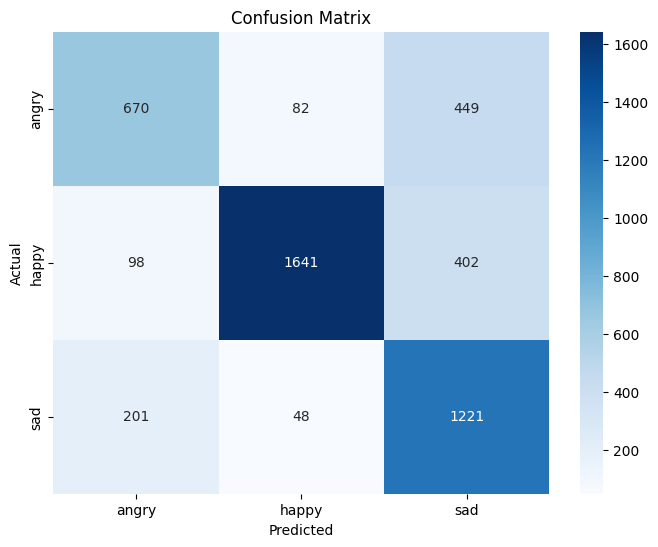

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, val_loader, class_names):
    model.eval()  # Set the model to evaluation mode
    val_predictions, val_labels = [], []
    
    with torch.no_grad():  # Disable gradient tracking
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get the predicted classes
            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    val_accuracy = accuracy_score(val_labels, val_predictions)
    print(f'Validation Accuracy: {val_accuracy:.4f}')

    # Print classification report for more metrics
    print("Classification Report:")
    print(classification_report(val_labels, val_predictions, target_names=class_names))

    # Optional: Plot confusion matrix
    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
# Assuming 'model' is your trained model, 'val_loader' is your validation DataLoader,
# and class_names is a list of the class names (e.g., ['angry', 'happy', 'sad']).
class_names = ['angry', 'happy', 'sad']  # Adjust this based on your dataset
evaluate_model(model, val_loader, class_names)
